# Load and minibatch MNIST data

In [2]:
# Load data, show some samples
using Knet
if ENV["HOME"] == "/mnt/juliabox"; Pkg.dir(path...)=joinpath("/home/jrun/.julia/v0.6",path...); end # juliabox fix
include(Knet.dir("data","mnist.jl"))
xtrn,ytrn,xtst,ytst = mnist()
map(summary,(xtrn,ytrn,xtst,ytst))

INFO: Loading MNIST...


("28×28×1×60000 Array{Float32,4}", "60000-element Array{UInt8,1}", "28×28×1×10000 Array{Float32,4}", "10000-element Array{UInt8,1}")

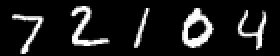

In [3]:
# Show some samples
using Images
hcat([mnistview(xtst,i) for i=1:5]...)

In [4]:
ytst[1:5]'

1×5 RowVector{UInt8,Array{UInt8,1}}:
 0x07  0x02  0x01  0x0a  0x04

In [5]:
# Minibatch data
Atype = gpu() >= 0 ? KnetArray{Float32} : Array{Float32}
dtst = minibatch(xtst,ytst,100;xtype=Atype) # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
dtrn = minibatch(xtrn,ytrn,100;xtype=Atype) # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
length(dtrn),length(dtst)

(600, 100)

In [6]:
# Here is the first minibatch
map(summary,first(dtst))  # (x,y) pair where x: 4-D Float32 array with X,Y,C,N  y: 1-D integer array

("28×28×1×100 Knet.KnetArray{Float32,4}", "100-element Array{UInt8,1}")

In [7]:
# Loss functions
zeroone(w,data,model) = 1 - accuracy(w,data,model)
softmax(w,data,model) = mean(softmax(w,x,y,model) for (x,y) in data)
softmax(w,x,y,model; o...) = nll(model(w,x;o...),y)
softgrad = grad(softmax)

In [ ]:
# Train model(w) with SGD and return a list containing w for every epoch
function train(w,data,predict; epochs=100,lr=0.1,o...)
    weights = Any[deepcopy(w)]
    for epoch in 1:epochs
        for (x,y) in data
            g = softgrad(w,x,y,predict;o...)
            update!(w,g,lr=lr)  # w[i] = w[i] - lr * g[i]
        end
        push!(weights,deepcopy(w))
    end
    return weights
end